In [1]:
# download data from # https://cellxgene.cziscience.com/collections/2d2e2acd-dade-489f-a2da-6c11aa654028
import os, sys
HOMEDIR = os.path.expanduser("~")
PROJDIR = rf"{HOMEDIR}/Islander"
sys.path.append(rf"{PROJDIR}/src")

import umap, numpy as np, pandas as pd, scanpy as sc, Data_Handler as dh, Utils_Handler as uh, Vis_Handler as vh
from tqdm.auto import tqdm
sc.settings.set_figure_params(dpi=80, facecolor="white")
pd.set_option('display.precision', 3)
sc.settings.verbosity = 3

### Select the subset of the data

In [2]:
adata = sc.read_h5ad("../data/lung_fetal_donor/emb.h5ad")
obsm_keys = list(adata.obsm)
for embed in obsm_keys:
    print("%20s, %d" % (embed, adata.obsm[embed].shape[1]))
    assert adata.obsm[embed].shape[0] == np.unique(adata.obsm[embed], axis=0).shape[0]

_subset = adata[["Fibroblast" in _ct for _ct in adata.obs["broad_celltype"]]]
_subset

          Geneformer, 512
     Geneformer_UMAP, 2
             Harmony, 100
        Harmony_UMAP, 2
            Islander, 16
          Islander_1, 16
     Islander_1_UMAP, 2
          Islander_2, 16
     Islander_2_UMAP, 2
          Islander_3, 16
     Islander_3_UMAP, 2
        Islander_SCL, 16
   Islander_SCL_UMAP, 2
        Islander_TRI, 16
   Islander_TRI_UMAP, 2
       Islander_UMAP, 2
     Islander_UMAP_1, 2
     Islander_UMAP_2, 2
     Islander_UMAP_3, 2
           Scanorama, 100
      Scanorama_UMAP, 2
             X_bbknn, 2
          X_null_001, 16
     X_null_001_UMAP, 2
          X_null_005, 16
     X_null_005_UMAP, 2
          X_null_010, 16
     X_null_010_UMAP, 2
               X_pca, 50
          X_pca_UMAP, 2
            X_scANVI, 30
       X_scANVI_UMAP, 2
             X_scGPT, 512
          X_scGPT_FT, 512
     X_scGPT_FT_UMAP, 2
        X_scGPT_UMAP, 2
              X_scVI, 30
         X_scVI_UMAP, 2
              X_tsne, 2
              X_umap, 2
     X_umap_origin

View of AnnData object with n_obs × n_vars = 31343 × 25955
    obs: 'batch', 'dissection', 'chemistry', 'percent_mito', 'n_counts', 'n_genes', 'doublet_scores', 'bh_pval', 'leiden', 'phase', 'S_score', 'G2M_score', 'new_celltype', 'big_cluster', 'broad_celltype', 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'development_stage_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'is_primary_data', 'organism_ontology_term_id', 'sex_ontology_term_id', 'tissue_ontology_term_id', 'donor_id', 'suspension_type', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', '_scvi_batch', '_scvi_labels', 'conditions_combined', 'stage'
    var: 'n_cells', 'gene_symbols', 'feature_is_filtered', 'feature_name', 'feature_reference', 'feature_biotype'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'assay_colors', 'assay_ontology_term_id_colors', 'batch_colors', 'big_cluster_colors', 'broad_celltype_colors

In [3]:
_list = list(_subset.obsm).copy()
for _obsm in _list:
    _subset.obsm[_obsm.lower()] = _subset.obsm[_obsm]
    del _subset.obsm[_obsm]
    
_list = list(_subset.obsm).copy()
for _obsm in _list:
    if "null" in _obsm:
        del _subset.obsm[_obsm]
    if "islander_tri" in _obsm:
        del _subset.obsm[_obsm]
    if "islander_scl" in _obsm:
        del _subset.obsm[_obsm]
    if "islander_umap_" in _obsm:
        del _subset.obsm[_obsm]
        
for _obsm in [
    "islander_1", "islander_2", "islander_3", 
    "islander_1_umap", "islander_2_umap", "islander_3_umap"
]:
    del _subset.obsm[_obsm]

In [4]:
_subset.obsm

AxisArrays with keys: geneformer, geneformer_umap, harmony, harmony_umap, islander, islander_umap, scanorama, scanorama_umap, x_bbknn, x_pca, x_pca_umap, x_scanvi, x_scanvi_umap, x_scgpt, x_scgpt_ft, x_scgpt_ft_umap, x_scgpt_umap, x_scvi, x_scvi_umap, x_tsne, x_umap, x_umap_original, scpoli, scpoli_umap

In [6]:
_list = list(_subset.obsm).copy()

for _obsm in _list:
    _subset.obsm["full_" + _obsm] = _subset.obsm[_obsm]
    del _subset.obsm[_obsm]
_subset.write_h5ad(rf"../data/lung_fetal_donor/Case/subset_fibro.h5ad", compression="gzip")

### Rerun all the integration methods on this subset (omitted), using scBenchmarker.py

### Benchmarking with scGraph

In [9]:
from scGraph import scGraph
sc.settings.verbosity = 1

_subset1 = sc.read_h5ad(rf"{PROJDIR}/data/lung_fetal_donor/Case/subset1_fibro.h5ad")

In [10]:
for _ct in _subset1.obs["development_stage"].unique():
    print(_ct, (_subset1.obs["development_stage"]==_ct).sum())

18th week post-fertilization human stage 4467
22nd week post-fertilization human stage 4211
15th week post-fertilization human stage 4616
20th week post-fertilization human stage 1248
Carnegie stage 19 3522
Carnegie stage 16 2641
9th week post-fertilization human stage 5070
11th week post-fertilization human stage 5568


In [11]:
_subset1.obs["new_celltype"].unique()

['Alveolar fibro', 'Interm fibro', 'Mid fibro', 'Adventitial fibro', 'Airway fibro', 'Early fibro', 'Mesenchymal 3', 'Mesenchymal 2', 'Mesenchymal 1']
Categories (9, object): ['Adventitial fibro', 'Airway fibro', 'Alveolar fibro', 'Early fibro', ..., 'Mesenchymal 1', 'Mesenchymal 2', 'Mesenchymal 3', 'Mid fibro']

In [12]:
_subset1.obsm

AxisArrays with keys: Harmony, Harmony_umap, Islander, Islander_umap, Scanorama, Scanorama_umap, X_bbknn, X_pca, X_pca_umap, X_scANVI, X_scANVI_umap, X_scVI, X_scVI_umap, X_tsne, X_umap, fastMNN_pca, fastMNN_pca_umap, fastMNN_umap, full_geneformer, full_geneformer_umap, full_harmony, full_harmony_umap, full_islander, full_islander_umap, full_scanorama, full_scanorama_umap, full_scpoli, full_scpoli_umap, full_x_bbknn, full_x_pca, full_x_pca_umap, full_x_scanvi, full_x_scanvi_umap, full_x_scgpt, full_x_scgpt_ft, full_x_scgpt_ft_umap, full_x_scgpt_umap, full_x_scvi, full_x_scvi_umap, full_x_tsne, full_x_umap, full_x_umap_original, scPoli, scPoli_umap, scgen_pca, scgen_pca_umap, scgen_umap

In [13]:
obsms = list(_subset1.obsm)

for _obsm in obsms:
    if "full_" in _obsm:
        continue
    if _subset1.obsm[_obsm].shape[1] <=2 :
        continue
    if f"{_obsm}_umap" in _subset1.obsm:
        continue
        
    print(_obsm)
    reducer = umap.UMAP(min_dist=0.5)
    embedding = reducer.fit_transform(_subset1.obsm[_obsm])
    _subset1.obsm["%s_umap" % _obsm] = embedding

In [14]:
_subset1.write_h5ad("../data/lung_fetal_donor/Case/subset1_fibro.h5ad")

In [21]:
_subset1

AnnData object with n_obs × n_vars = 31343 × 25955
    obs: 'batch', 'dissection', 'chemistry', 'percent_mito', 'n_counts', 'n_genes', 'doublet_scores', 'bh_pval', 'leiden', 'phase', 'S_score', 'G2M_score', 'new_celltype', 'big_cluster', 'broad_celltype', 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'development_stage_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'is_primary_data', 'organism_ontology_term_id', 'sex_ontology_term_id', 'tissue_ontology_term_id', 'donor_id', 'suspension_type', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', '_scvi_batch', '_scvi_labels', 'conditions_combined', 'stage'
    var: 'n_cells', 'gene_symbols', 'feature_is_filtered', 'feature_name', 'feature_reference', 'feature_biotype'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'assay_colors', 'assay_ontology_term_id_colors', 'batch_colors', 'big_cluster_colors', 'broad_celltype_colors', 'cell

In [15]:
scgraph = scGraph(
    adata_path="/home/wangh256/Islander/data/lung_fetal_donor/Case/subset1_fibro.h5ad", 
    batch_key="batch", 
    label_key="new_celltype"
)
res_subset1 = scgraph.main()

Processing batches, calcualte centroids and pairwise distances


  0%|          | 0/29 [00:00<?, ?it/s]

Skipped batch 5891STDY8062352, due to < 100 cells
Skipped batch WSSS_F_LNG8713188, due to < 100 cells
Skipped batch WSSS_F_LNG8713189, due to < 100 cells
Skipped batch WSSS_F_LNG8713190, due to < 100 cells
Skipped batch WSSS_F_LNG8713191, due to < 100 cells


In [16]:
res_subset1.sort_values(ascending=False, by="Corr-Weighted").head(10)

Rank-PCA  Corr-PCA  Corr-Weighted
full_harmony          0.704     0.889          0.595
Harmony               0.641     0.862          0.516
full_x_scgpt_ft       0.679     0.881          0.508
full_scanorama        0.649     0.873          0.491
Harmony_umap          0.594     0.766          0.473
full_scpoli           0.656     0.824          0.473
full_harmony_umap     0.596     0.708          0.442
Scanorama             0.598     0.851          0.422
full_x_bbknn          0.632     0.746          0.404
fastMNN_pca           0.545     0.871          0.376

In [17]:
df = res_subset1
_filtered_df_scgraph = df[(df.index.str.contains('_umap') & ~df.index.str.contains('full_')) | (df.index.str.contains('full_x_umap_original')) | (df.index.str.contains('X_bbknn'))]
_filtered_df_scgraph.sort_values(ascending=False, by="Corr-Weighted")

Rank-PCA  Corr-PCA  Corr-Weighted
Harmony_umap             0.594     0.766          0.473
full_x_umap_original     0.528     0.661          0.276
X_scVI_umap              0.533     0.757          0.258
X_bbknn                  0.588     0.718          0.247
X_scANVI_umap            0.536     0.662          0.217
X_pca_umap               0.522     0.631          0.184
Scanorama_umap           0.482     0.622          0.136
X_umap                   0.447     0.609          0.071
fastMNN_umap             0.362     0.499         -0.097
fastMNN_pca_umap         0.365     0.504         -0.122
Islander_umap            0.319     0.583         -0.130
scPoli_umap              0.325     0.565         -0.138
scgen_pca_umap           0.285     0.536         -0.172
scgen_umap               0.304     0.538         -0.187

    full_x_umap_original is the author's released annotation.

### Visualization

Harmony_umap


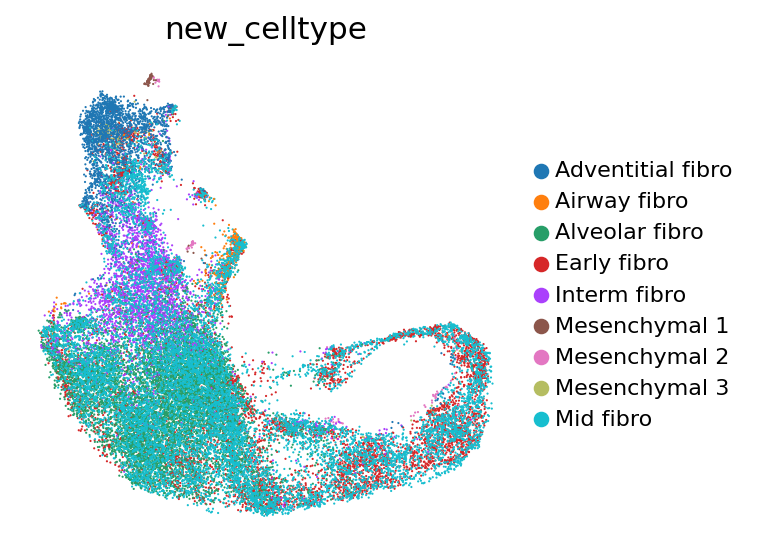

Islander_umap


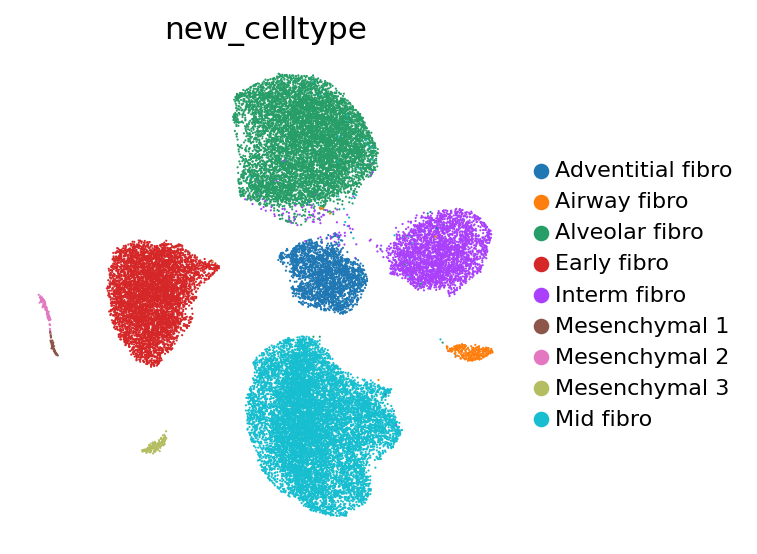

Scanorama_umap


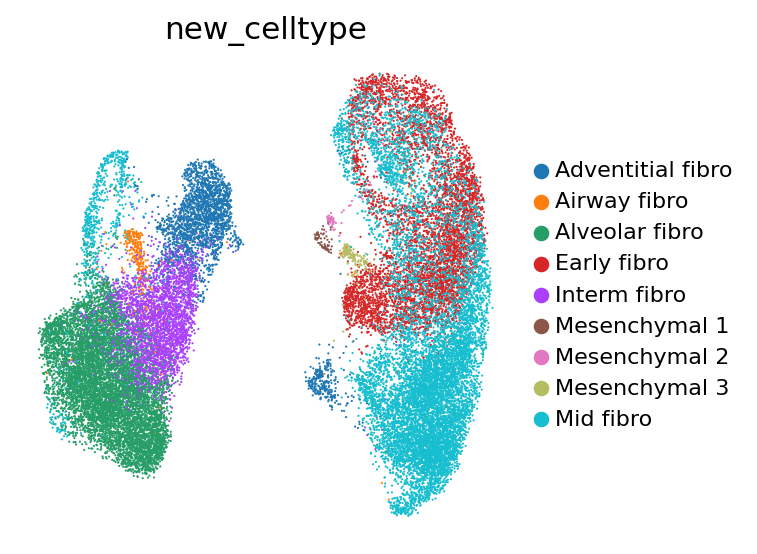

X_bbknn


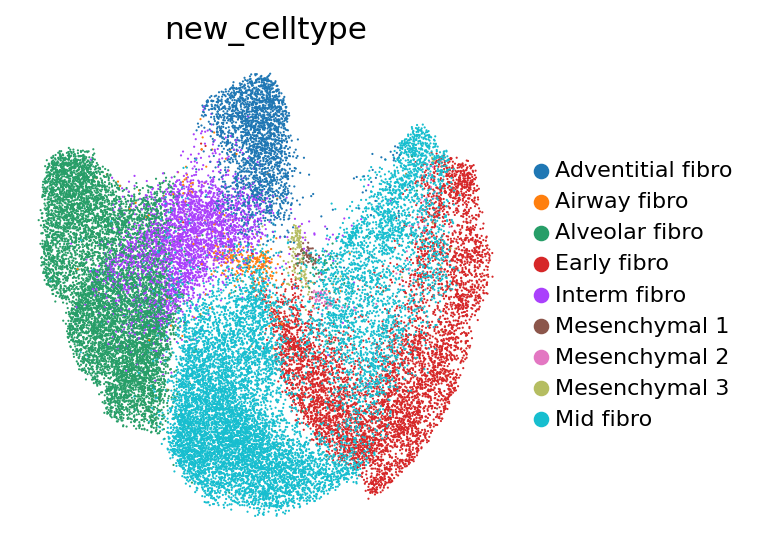

X_pca_umap


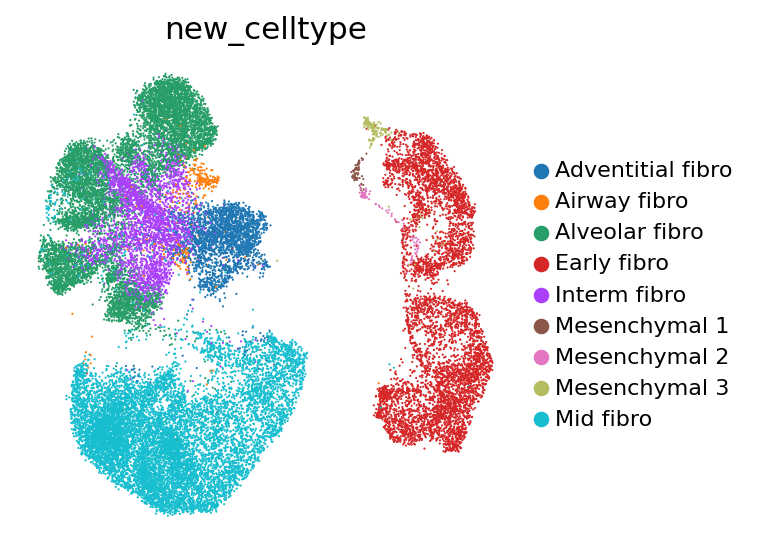

X_scANVI_umap


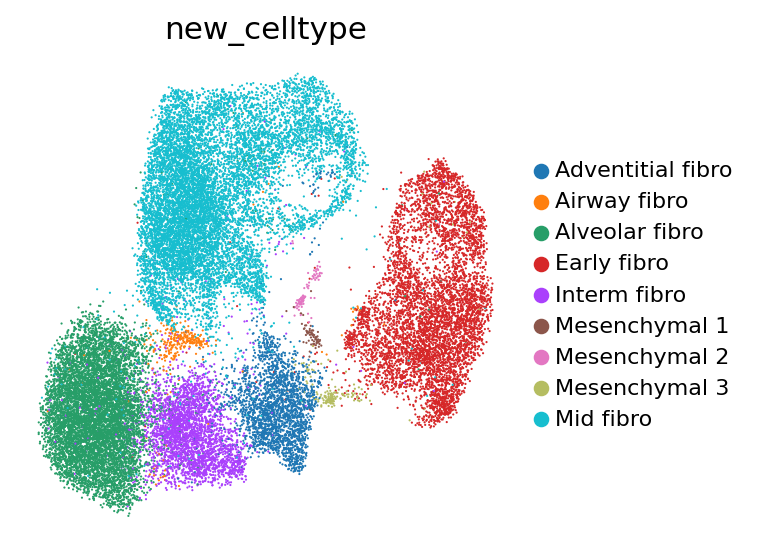

X_scVI_umap


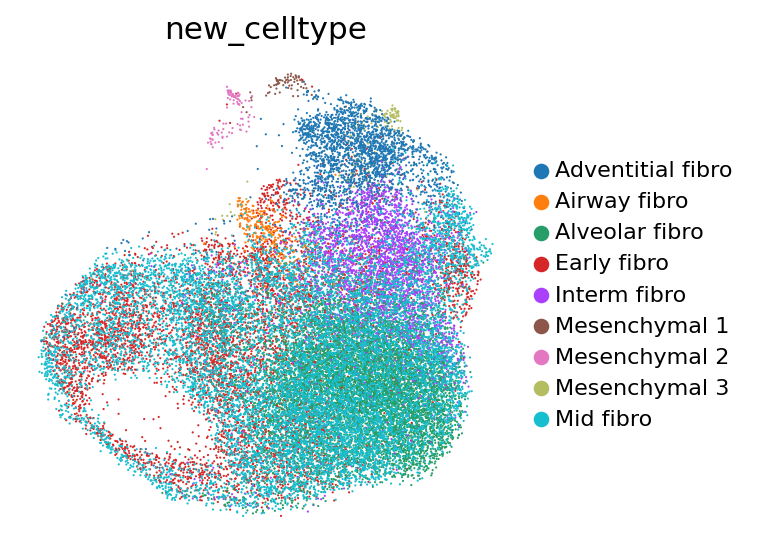

X_umap


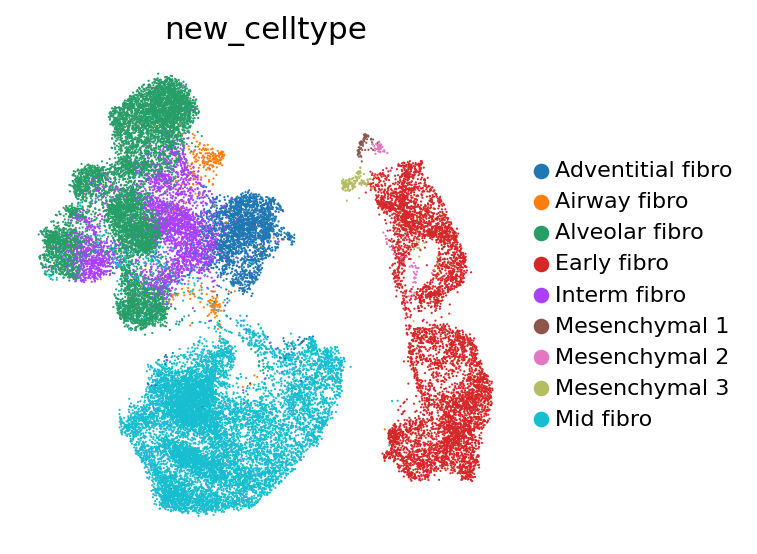

fastMNN_pca_umap


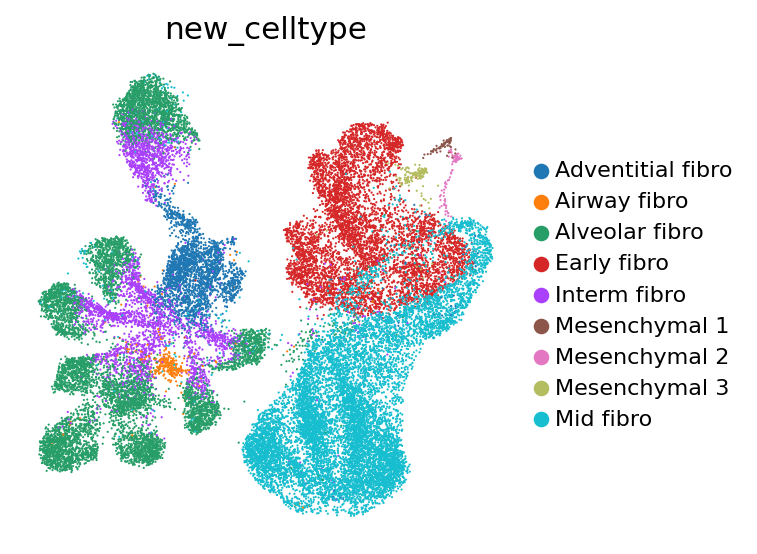

fastMNN_umap


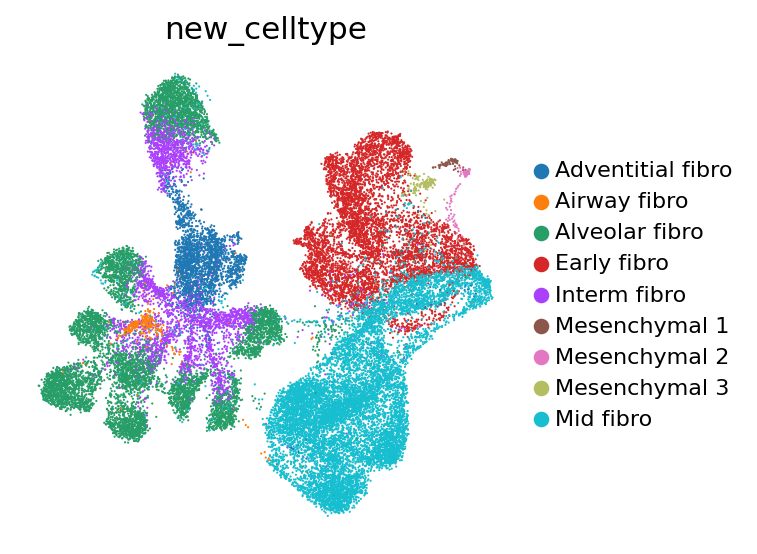

full_x_umap_original


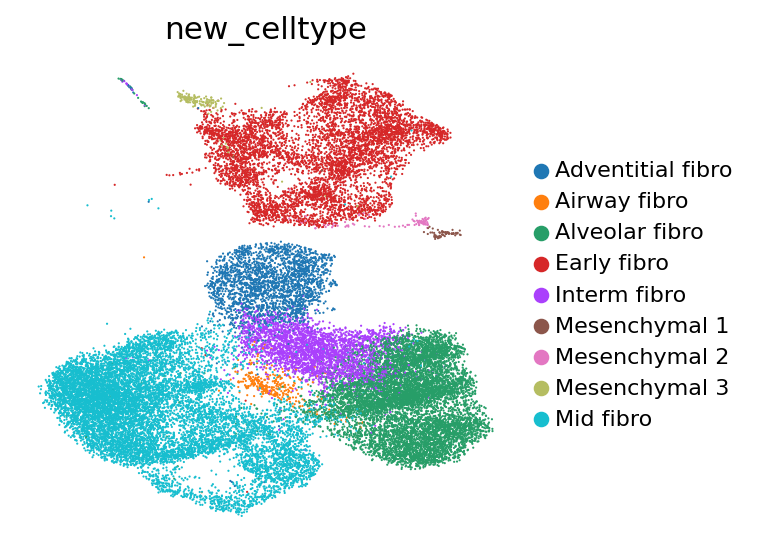

scPoli_umap


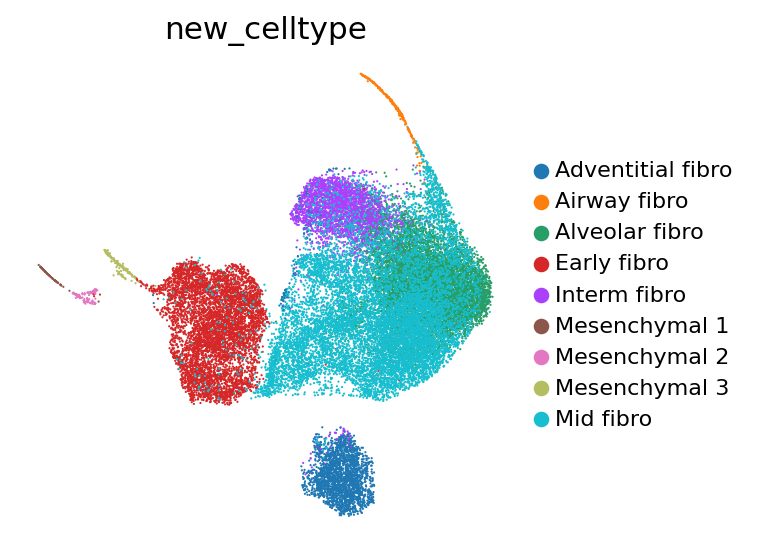

scgen_pca_umap


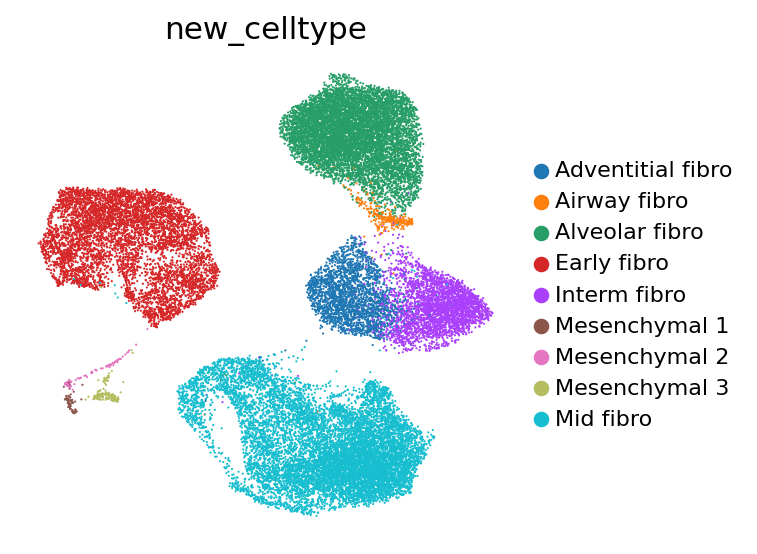

scgen_umap


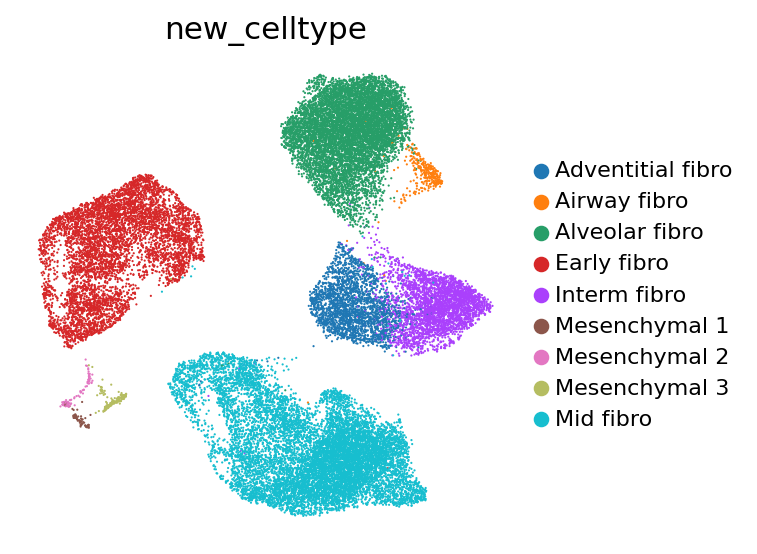

In [20]:
for _obsm in _filtered_df_scgraph.index:
    print(_obsm)
    sc.pl.embedding(_subset1, basis=_obsm, color=["new_celltype"], **vh.cfg)